In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

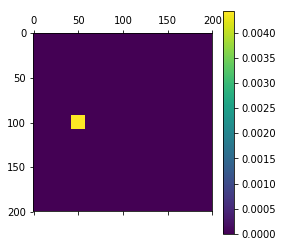

In [9]:
def square_probability(current_i, current_j, width, size):
    grid_ii, grid_jj = np.mgrid[0:size, 0:size]
    inside_mask = (np.abs(grid_ii - current_i) <= width // 2) & (np.abs(grid_jj - current_j) <= width // 2)
    p_next_step = inside_mask / inside_mask.sum()
    return p_next_step

p = square_probability(100, 50, 14, 200)
plt.matshow(p)
plt.colorbar()

# Code to build context maps

In [15]:
def flat_context_map_builder(size):
    """ A context map where all positions are equally likely. """
    return np.ones((size, size))


def hills_context_map_builder(size):
    """ A context map with bumps and valleys. """
    grid_ii, grid_jj = np.mgrid[0:size, 0:size]
    i_waves = np.sin(grid_ii/130) + np.sin(grid_ii/10)
    i_waves /= i_waves.max()
    j_waves = np.sin(grid_jj/100) + np.sin(grid_jj/50)+ np.sin(grid_jj/10)
    j_waves /= j_waves.max()
    context_map = j_waves + i_waves
    return context_map


def labyrinth_context_map_builder(size):
    """ A context map that looks like a labyrinth. """
    context_map = np.ones((size, size))
    context_map[50:100, 50:60] = 0
    context_map[20:89, 80:90] = 0
    context_map[90:120, 0:10] = 0
    context_map[120:size, 30:40] = 0
    context_map[180:190, 50:60] = 0

    context_map[50:60, 50:200] = 0
    context_map[179:189, 80:130] = 0
    context_map[110:120, 0:190] = 0
    context_map[120:size, 30:40] = 0
    context_map[180:190, 50:60] = 0

    return context_map


# Classes to compute next step proposal maps

Next step proposal classes have a method `next_step_proposal` that takes the current position and returns a 2D next step proposal probaility.

In [19]:
class GaussianNextStepProposal:
    """ 2D gaussian next step proposal. """

    def __init__(self, size, sigma_i, sigma_j):
        self.sigma_i = sigma_i
        self.sigma_j = sigma_j
        self.size = size
        self._grid_ii, self._grid_jj = np.mgrid[0:size, 0:size]

    def next_step_proposal(self, current_i, current_j):
        """ Create the 2D proposal map for the next step of the walker. """
        grid_ii, grid_jj = self._grid_ii, self._grid_jj
        sigma_i, sigma_j = self.sigma_i, self.sigma_j

        rad = (
            (((grid_ii - current_i) ** 2) / (sigma_i ** 2))
            + (((grid_jj - current_j) ** 2)/ (sigma_j ** 2))
        )

        p_next_step = np.exp(-(rad / 2.0)) / (2.0 * np.pi * sigma_i * sigma_j)
        return p_next_step / p_next_step.sum()


class SquareNextStepBuilder:
    """ 2D gaussian next step proposal. """

    def __init__(self, size, width):
        self.width = width
        self.size = size
        self._grid_ii, self._grid_jj = np.mgrid[0:size, 0:size]

    def next_step_proposal(self, current_i, current_j):
        """ Create the 2D proposal map for the next step of the walker. """
        inside_mask = (
            (np.abs(self._grid_ii - current_i) <= self.width // 2) 
            & (np.abs(self._grid_jj - current_j) <= self.width // 2)
        )
        p_next_step = inside_mask / inside_mask.sum()
        return p_next_step


# The Walker

In [20]:
class Walker:
    """ The Walker knows how to walk at random on a context map,. """

    def __init__(self, size, context_map, next_step_builder):
        self.size = size
        self.context_map = context_map
        self.next_step_builder = next_step_builder

    @classmethod
    def from_context_map_builder(cls, size, context_map_builder, next_step_builder):
        """Initialize the context map from an external builder.

        `builder` is a callable that takes a `size` as input parameter
        and outputs a `size` x `size` numpy array of positive values.
        """
        context_map = context_map_builder(size)
        context_map /= context_map.sum()
        return cls(size, context_map, next_step_builder)
        
    # --- Walker public interface

    def sample_next_step(self, current_i, current_j, random_state=np.random):
        """ Sample a new position for the walker. """
        
        # Combine the next-step proposal with the context map to get a next-step probability map
        next_step_map = self.next_step_builder.next_step_proposal(current_i, current_j)
        selection_map = self._compute_next_step_probability(next_step_map)

        # Draw a new position from the next-step probability map
        r = random_state.rand()
        cumulative_map = np.cumsum(selection_map)
        cumulative_map = cumulative_map.reshape(selection_map.shape)
        i_next, j_next = np.argwhere(cumulative_map >= r)[0]

        return i_next, j_next
        
    # --- Walker non-public interface

    def _compute_next_step_probability(self, next_step_map):
        """ Compute the next step probability map from next step proposal and context map. """
        next_step_probability = next_step_map * self.context_map
        next_step_probability /= next_step_probability.sum()
        return next_step_probability


def plot_trajectory(trajectory, context_map):
    """ Plot a trajectory over a context map. """
    trajectory = np.asarray(trajectory)
    plt.matshow(context_map)
    plt.plot(trajectory[:, 1], trajectory[:, 0], color='r')
    plt.show()


# Simulate a trajectory

In [24]:
next_step_builder = SquareNextStepBuilder(size=200, width=5)
walker = Walker.from_context_map_builder(
    size=200,
    context_map_builder=hills_context_map_builder,
    next_step_builder=next_step_builder,
)

i, j = 100, 50
trajectory = []
for _ in range(1000):
    i, j = walker.sample_next_step(i, j)
    trajectory.append((i, j))

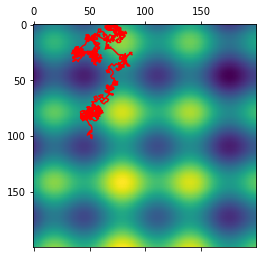

In [25]:
plot_trajectory(trajectory, walker.context_map)
